In [1]:
import numpy as np
from numba import njit
from secondaryTrispectrum import *
from trispectra import *
import matplotlib.pyplot as plt
from scipy import interpolate
import vegas
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams.update({'font.size': 12})
n_jobs=-1 #number of threads

In [7]:
zs,rs = np.genfromtxt("comovingD.dat").T
znmids = np.arange(1,len(zs),2)

VzTotal = 4.*np.pi/3. * (rs[-1]**3-rs[0]**3)
VzTotal

Vzs = np.array([4.*np.pi/3. * (rs[i+1]**3-rs[i-1]**3) for i in znmids])

# @njit
def kmaxp(b,zn):
    c=299792.458;   # speed of light [ km/s ]
    return 2*np.pi*1420405751.7667*b/rs[zn]/(1+zs[zn])/c

# @njit
def kmaxz(windownu,zn):
    return np.sqrt(17/3) / (20 * windownu * np.sqrt(1+zs[zn]))

(232, 30)


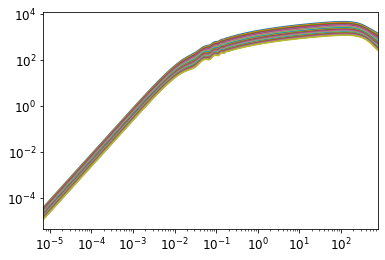

In [8]:
transferdata = np.genfromtxt("BaryonTransfer-z100-z30-delta05.dat")
kTF = transferdata[:,0]
print(transferdata.shape)
TFdata = np.flip(transferdata[:,1:],axis=1)
plt.loglog(kTF,TFdata)
plt.xlim(kTF[0],kTF[-1])
plt.show()
TFint = interpolate.interp1d(kTF,TFdata[:,znmids],axis=0,bounds_error=False)

In [9]:
dataT21 = np.genfromtxt("T21.dat")
dataCoef = np.genfromtxt("alphacoeffdata.dat")

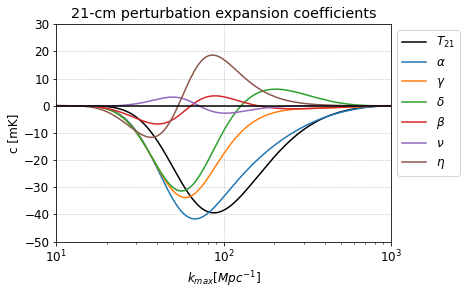

In [10]:
names = ['$T_{21}$','$\\alpha$','$\\gamma$','$\\delta$','$\\beta$','$\\nu$','$\\eta$']
plt.semilogx(dataT21[:,0],dataT21[:,1],'-k',label=names[0])
[plt.semilogx(dataCoef[:,0],dataCoef[:,n],label=names[n]) for n in range(1,dataCoef.shape[1])]
plt.gca().set_prop_cycle(None)
plt.semilogx([10,1000],[0,0],'-k')
plt.xlim(10,1000)
plt.grid(linestyle=":")
plt.xlabel("$k_{max} [Mpc^{-1}]$")
plt.ylabel("c [mK]")
plt.title("21-cm perturbation expansion coefficients")
plt.ylim(-50,30)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [11]:
T21zs = dataT21[:,0]
Coefzs = dataCoef[:,0]

T21s = dataT21[:,1]
alphas = dataCoef[:,1]
betas  = dataCoef[:,4]
gammas = dataCoef[:,2]
deltas = dataCoef[:,3]
nus    = dataCoef[:,5]
etas   = dataCoef[:,6]

In [12]:
def integrand(k,kmin,kmaxps,kmaxzs,zn,S1,S2,fn1,fn2,munu,T21,alpha,beta,gamma,delta,eta,nu):
    # print(k.shape)
    Fish = np.zeros((len(k),14))
    
    Vz = 4.*np.pi/3. * (rs[zn+1]**3-rs[zn-1]**3)
    k1max = kmaxps
    k1p = k1max*k[:,0]
    k1zmax = kmaxzs
    k1z = k1zmax*k[:,1]
    k1 = np.sqrt(k1p**2 + k1z**2)

    k2max = kmaxps
    k2p = k2max*k[:,2]
    k2zmax = kmaxzs
    k2z = k2zmax*k[:,3]
    k2= np.sqrt(k2p**2 + k2z**2)

    k3max = kmaxps
    k3p = k3max*k[:,4]
    k3zmax = kmaxzs
    k3z = k3zmax*k[:,5]
    k3 = np.sqrt(k3p**2 + k3z**2)

    phi2 = k[:,6]
    phi3 = k[:,7]
    
    k4p = np.sqrt(k1p**2 + k2p**2 + k3p**2 + 2*k1p*k2p*np.cos(phi2) + 2*k1p*k3p*np.cos(phi3) + 2*k3p*k2p*np.cos(phi2-phi3))
    k4z = -k1z-k2z-k3z
    k4 = np.sqrt(k4p**2 + k4z**2)

    K12p = np.sqrt(k1p**2 + k2p**2 + 2*k1p*k2p*np.cos(phi2))
    K12z = k1z+k2z
    K12 = np.sqrt(K12p**2 + K12z**2)

    K13p = np.sqrt(k1p**2 + k3p**2 + 2*k1p*k3p*np.cos(phi3))
    K13z = k1z+k3z
    K13 = np.sqrt(K13p**2 + K13z**2)

    K14p = np.sqrt(k2p**2 + k3p**2 + 2*k2p*k3p*np.cos(phi2-phi3))
    K14z = k1z+k4z
    K14 = np.sqrt(K14p**2 + K14z**2)

    dVol = 2*np.pi * k1p * k2p * k3p * k1max * k2max * k3max * k1zmax * k2zmax * k3zmax # 2pi comes from angular integration of phi1
    
    bools = np.abs(k1z) < kmin
    bools+= np.abs(k2z) < kmin
    bools+= np.abs(k3z) < kmin
    bools+= np.abs(k4z) < kmin
    bools+= np.abs(K12z) < kmin
    bools+= np.abs(K13z) < kmin
    bools+= np.abs(K14z) < kmin
    
    bools+= np.abs(k1z) > kmaxzs
    bools+= np.abs(k2z) > kmaxzs
    bools+= np.abs(k3z) > kmaxzs
    bools+= np.abs(k4z) > kmaxzs
    bools+= np.abs(K13z) > 2*kmaxzs
    bools+= np.abs(K12z) > 2*kmaxzs
    bools+= np.abs(K14z) > 2*kmaxzs
    
    bools+= K12p > 2*kmaxps
    bools+= K13p > 2*kmaxps
    bools+= K14p > 2*kmaxps
    
    bools+= k1p > kmaxps
    bools+= k2p > kmaxps
    bools+= k3p > kmaxps
    bools+= k4p > kmaxps

    mu1 = ((k1z/k1)**2)
    mu2 = ((k2z/k2)**2)
    mu3 = ((k3z/k3)**2)
    mu4 = ((k4z/k4)**2)
    mu12 = ((K12z/K12)**2)
    mu13 = ((K13z/K13)**2)
    mu14 = ((K14z/K14)**2)

    TF1 = np.interp(k1,kTF,TFdata[:,zn])
    TF2 = np.interp(k2,kTF,TFdata[:,zn])
    TF3 = np.interp(k3,kTF,TFdata[:,zn])
    TF4 = np.interp(k4,kTF,TFdata[:,zn])
    TF12 = np.interp(K12,kTF,TFdata[:,zn])
    TF13 = np.interp(K13,kTF,TFdata[:,zn])
    TF14 = np.interp(K14,kTF,TFdata[:,zn])
    
    P1prim = P(k1)
    P2prim = P(k2)
    P3prim = P(k3)
    P4prim = P(k4)
    P12prim = P(K12)
    P13prim = P(K13)
    P14prim = P(K14)

    P1 = TF1**2 * P1prim
    P2 = TF2**2 * P2prim
    P3 = TF3**2 * P3prim
    P4 = TF4**2 * P4prim
    P12 = TF12**2 * P12prim
    P13 = TF13**2 * P13prim
    P14 = TF14**2 * P14prim

    pre1 = alpha + T21 * mu1
    pre2 = alpha + T21 * mu2
    pre3 = alpha + T21 * mu3
    pre4 = alpha + T21 * mu4

    P1T = pre1**2 * P1
    P2T = pre2**2 * P2
    P3T = pre3**2 * P3
    P4T = pre4**2 * P4

    # print(k1.shape,mu1.shape,P1.shape)

    if S1 < 7:
        c1 = Secondary7(S1,k1,k2,k3,k4,K12,K13,K14,mu1,mu2,mu3,mu4,mu12,mu13,mu14,P1,P2,P3,P4,P12,P13,P14,T21,alpha,beta,gamma,delta,eta,nu) ## gives back all permutations already
    if S1 == 7:
        c1 = pre1*pre2*pre3*pre4*TF1*TF2*TF3*TF4*fn1(k1,k2,k3,k4,K12,K14,K13,munu) ## note the different ordering of K13 and K14 compared to secondary...

    if S2 == S1 and S1 < 7:
        c2 = c1
    elif S2 < 7:
        c2 = Secondary7(S2,k1,k2,k3,k4,K12,K13,K14,mu1,mu2,mu3,mu4,mu12,mu13,mu14,P1,P2,P3,P4,P12,P13,P14,T21,alpha,beta,gamma,delta,eta,nu)
    elif S2 == 7:
        c2 = pre1*pre2*pre3*pre4*TF1*TF2*TF3*TF4*fn2(k1,k2,k3,k4,K12,K14,K13,munu)

    Fish = c1*c2 / P1T/P2T/P3T/P4T
    Fish[bools] = 0
    Fish *= Vz * dVol
    
    result = Fish/24 /(2*np.pi)**9 
    return result

def Fisher(kmin,base,windownu,zn,S1,S2,fn1,fn2,munu,rtol):
    z = zs[zn]
    kmaxps = kmaxp(base,zn)
    kmaxzs = kmaxz(windownu,zn)
    
    print("z",zn,zs[zn])
    print("window",windownu,"MHz")
    print("baseline",base,"km")
    print("kmax perp",kmaxps)
    print("kmax los",kmaxzs)
    print("kmax tot",np.sqrt(kmaxps**2 + kmaxzs**2))
    
    T21 = np.interp(z,T21zs,T21s)
    alpha = np.interp(z,Coefzs,alphas)
    beta = np.interp(z,Coefzs,betas)
    gamma = np.interp(z,Coefzs,gammas)
    delta = np.interp(z,Coefzs,deltas)
    eta = np.interp(z,Coefzs,etas)
    nu = np.interp(z,Coefzs,nus)
    print("T21",T21)
    print("alpha",alpha)
    print("beta",beta)
    print("gamma",gamma)
    print("delta",delta)
    print("eta",eta)
    print("nu",nu)

    @vegas.batchintegrand
    def integrandbatch(k):
        return integrand(k,kmin,kmaxps,kmaxzs,zn,S1,S2,fn1,fn2,munu,T21,alpha,beta,gamma,delta,eta,nu)

    integ = vegas.Integrator([[0,1],[-1,1],[0,1],[-1,1],[0,1],[-1,1],[0,2*np.pi],[0,2*np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e6,rtol=rtol)
    print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)
    print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    # rerr = 1
    # ii = 1
    # while rerr > 0.001 and ii<10:
    #     results = integ(integrandbatch,nitn=10,neval=1e6,rtol=0.001,nhcube_batch=1e6)
    #     print(results.summary())
    #     mean = results.mean
    #     rerr = np.abs(results.sdev/mean)
    #     ii+=1
    print(S1,S2,mean,rerr)
    return base, windownu, zn, S1, S2, Q, mean, rerr

%time Fisher(0.01,10,0.1,1,0,7,None,Tint,0.25,0.01)

z 1 32.5
window 0.1 MHz
baseline 10 km
kmax perp 0.7622812837001205
kmax los 0.20564181776557594
kmax tot 0.7895323379656047
T21 -5.9678034799358946
alpha -12.510719492229152
beta -5.46857774911387
gamma -12.81846271431063
delta -12.911951011897663
eta -10.683746022714763
nu 1.0907322999082056
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   -0.002238(75)   -0.002238(75)       0.00     1.00
  2   -0.002249(48)   -0.002246(41)       0.02     0.90
  3   -0.002261(26)   -0.002256(22)       0.05     0.95

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   -0.002271(24)   -0.002271(24)       0.00     1.00
  2   -0.002312(35)   -0.002284(20)       0.92     0.34

0 7 -0.002284087482022401 0.008594481823297693
CPU times: user 21.8 s, sys: 348 ms, total: 22.1 s
Wall time: 22.3 s


(10,
 0.1,
 1,
 0,
 7,
 0.3363969350020366,
 -0.002284087482022401,
 0.008594481823297693)

## Calculate the 7x7 matrix for secondary trispectrum

In [11]:
calculate secondaries and their overlap

baselines = [1,10,100,1000]
windows = [0.01,0.001]
for window in windows:
    tasks = [delayed(Fisher)(0.01,base,window,zn,S1,S2,Teq1,Teq1,0,0.01) for base in baselines for zn in znmids for S1 in range(7) for S2 in range(S1,7)]
    tasks = tasks[::-1]
    print(len(tasks),"tasks!")
    data = np.array(Parallel(n_jobs=-1,verbose=10)(tasks))
    data = data[::-1]
    np.savetxt(f"BaselineData/FisherBaselineSec{window}.dat",data)

## Calculate the row/colum for secondary x intermediate

In [ ]:
# calculate overlap with secondaries and self

baselines = [1,10,100,1000]
windows = [0.1,0.01,0.001]
mus = [0.25,1,1.25]
for mu in mus:
    tasks = [delayed(Fisher)(0.01,base,window,zn,S1,7,Tint,Tint,mu,0.01) for window in windows for base in baselines for zn in znmids for S1 in range(8)]
    print(len(tasks),"tasks!")
    tasks = tasks[::-1]
    data = np.array(Parallel(n_jobs=-1,verbose=10)(tasks))
    data = data[::-1]
    np.savetxt(f"BaselineData/FisherBaselineSecTInt{mu}.dat",data)

## Calculate the row/column for intermediate x common trispectra

In [ ]:
baselines = [1,10,100,1000]
windows = [0.1,0.01,0.001]
mus = [1.25]
shapes = [TtauNL,TgNL,Teq1,Teq2,Teq3]
for mu in mus:
    tasks = [delayed(Fisher)(0.01,base,window,zn,7,7,Tint,shape,mu,0.001) for window in windows for base in baselines for zn in znmids for shape in shapes]
    print(len(tasks),"tasks!")
    tasks = tasks[::-1]
    data = np.array(Parallel(n_jobs=-1,verbose=10)(tasks))
    data = data[::-1]
    np.savetxt(f"BaselineData/FisherBaselinePrimTInt{mu}.dat",data)